In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(12345)
np.random.seed(12345)

In [2]:
DELTA = 0.95
num_episodes = 1500000
alpha = 0.15
eps = 1e-5
actions_space = np.arange(1.43, 2.0, 0.04)
n_actions = actions_space.size
n_agents = 2

In [3]:
quality = np.ones(n_agents) * 2
margin_cost = np.ones(n_agents)
horizon = 1/4
a0 = 0

def reward_comp(action):
    # Compute profits for all agents
    # Input: actions taken by all agents, shape: n_agents; value: from actions_space = np.array(0, 50, 0.1)
    # Output: profits for all agents, n_agents
    price = actions_space[action]
    demand = np.exp((quality - price) / horizon)
    demand = demand / (np.sum(demand) + np.exp(a0 / horizon))
    reward = np.multiply(price - margin_cost, demand)
    return reward

In [4]:
reward_sum = np.zeros(n_actions)
for self_act in range(n_actions):
    for rival_act in range(n_actions):
        if rival_act == self_act: 
            continue
        state = np.array([self_act, rival_act])
        reward_sum[self_act] += reward_comp(state)[0]
reward_sum = reward_sum/(1 - DELTA)/np.power(n_actions, n_agents-1)

In [5]:
# Q matrix, first two indices as states, last one as actions
Q = np.zeros((n_agents, n_actions, n_actions, n_actions))
for agent in range(n_agents):
    for act in range(n_actions):
        Q[agent, :, :, act] = reward_sum[act]

steps_done = np.zeros(n_agents)

def select_action(agent, state):
    # state should be like [1, 2]
    global steps_done
    sample = random.random()
    eps_threshold = np.exp(-eps * steps_done[agent])
    steps_done[agent] += 1
    if sample > eps_threshold:
        return Q[agent][state[0]][state[1]].argmax()
    else:
        return np.random.randint(0, n_actions, 1, dtype=int)

state_hist = []
# Initialize the environment and state
state = np.random.randint(0, n_actions, size=n_agents)
state_hist.append(state)
# Counter for variations in heat
count = 0

heat_unique0 = []
heat_freq0 = []
heat_unique1 = []
heat_freq1 = []

for i_episode in range(num_episodes):
    # For each agent, select and perform an action
    action = np.zeros(n_agents, dtype=int)
    for i in range(n_agents):
        action[i] = select_action(i, state)
    sample = random.random()
    if np.exp(-eps*i_episode) < sample:
        action[0] = 10
        
    reward = reward_comp(action)

    # Move to the next state
    next_state = action
    
    old_heat0 = Q[0].argmax(2)
    old_heat1 = Q[1].argmax(2)
    

    if reward[0] < reward[1]:
        i = 0
        Q[i][state[0]][state[1]][action[i]] = (1-alpha)*Q[i][state[0]][state[1]][action[i]] + \
            alpha*(reward[i] + DELTA*Q[i][next_state[0]][next_state[1]].max())
    elif reward[0] == reward[1]:
        i = 0
        Q[i][state[0]][state[1]][action[i]] = (1-alpha)*Q[i][state[0]][state[1]][action[i]] + \
            alpha*(reward[i] + DELTA*Q[i][next_state[0]][next_state[1]].max())
        i = 1
        Q[i][state[0]][state[1]][action[i]] = (1-alpha)*Q[i][state[0]][state[1]][action[i]] + \
            alpha*(reward[i] + DELTA*Q[i][next_state[0]][next_state[1]].max())
    else:
        i = 1
        Q[i][state[0]][state[1]][action[i]] = (1-alpha)*Q[i][state[0]][state[1]][action[i]] + \
            alpha*(reward[i] + DELTA*Q[i][next_state[0]][next_state[1]].max())     
    
    new_heat0 = Q[0].argmax(2)
    new_heat1 = Q[1].argmax(2)
            
    if np.sum(np.abs(old_heat0 - new_heat0)) == 0 and np.sum(np.abs(old_heat1 - new_heat1)) == 0:
        count += 1
    else:
        count = 0
            

    if i_episode%40000 == 0:
        print('price', actions_space[action])
        print('count', count)
    
    if i_episode%5000 == 0:
        uniq0, freq0 = np.unique(new_heat0, return_counts=True)
        heat_unique0.append(uniq0)
        heat_freq0.append(freq0)

        uniq1, freq1 = np.unique(new_heat1, return_counts=True)
        heat_unique1.append(uniq1)
        heat_freq1.append(freq1)

    state = next_state
    state_hist.append(state)
    
    if count == 150000:
        print('Terminate condition satisfied.')
        print('state', state_hist[-10:])
        break

price [1.95 1.47]
count 1
price [1.87 1.99]
count 42
price [1.83 1.43]
count 3
price [1.83 1.83]
count 203
price [1.83 1.83]
count 28
price [1.83 1.83]
count 608
price [1.83 1.83]
count 1107
price [1.83 1.83]
count 5921
price [1.83 1.83]
count 1491
price [1.83 1.83]
count 5891
price [1.83 1.83]
count 45891
price [1.83 1.83]
count 85891
price [1.83 1.83]
count 125891
price [1.83 1.83]
count 16095
price [1.83 1.83]
count 56095
price [1.83 1.83]
count 96095
price [1.83 1.83]
count 136095
Terminate condition satisfied.
state [array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10]), array([10, 10])]


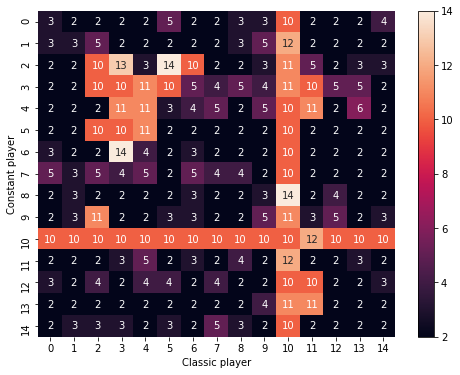

In [6]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(new_heat1, cbar=False, annot=True)
plt.xlabel('Classic player')
plt.ylabel('Constant player')
cbar = ax.figure.colorbar(ax.collections[0])
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12, 14])
fig = ax.get_figure()
# fig.savefig('mimic.eps', format='eps', dpi=500, bbox_inches='tight', pad_inches=0.1)